In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity

from torchvision import transforms
from PIL import Image

In [2]:
#if access to laptop Pim: True 
# else: False
LAPTOP_PIM = True

In [3]:
#path to concept overview csv
csv_path = '../data/concept_overview_latent_space.csv'

In [4]:
if os.path.exists(csv_path):
    cdf = pd.read_csv(csv_path, index_col=0)
else:
    training_concepts = pd.read_csv('../data/training_tau_latent.csv', index_col = 0)
    training_concepts.sort_index(inplace=True)
    training_concepts['Training tau'] = training_concepts['Training tau'].round(3)
    print(training_concepts.shape)
    training_concepts.head();

    latent_concept_pairs = pd.read_csv('../data/broden_concepts_glove_neighbors.csv', index_col = 0)
    print(latent_concept_pairs.shape)
    latent_concept_pairs.head();

    cdf= training_concepts.merge(latent_concept_pairs, 
                                 how='left', 
                                 left_on = 'Training Concept', 
                                 right_on='Broden concept').drop(columns= ['Broden concept'])
    cdf['GloVe Concept'] = cdf['GloVe neighbor']
    cdf.drop(columns=['GloVe neighbor'], inplace=True)
    print(cdf.shape)

    latent_concepts = pd.read_csv('../data/new_glove_tau_latent.csv', index_col =0)

    cdf = cdf.merge(latent_concepts,
                    how='left', 
                    left_on = 'GloVe Concept', 
                    right_on = 'New GloVe Concept').drop(columns=['New GloVe Concept'])
    cdf['GloVe tau'] = cdf['GloVe tau'].round(3)

    cdf.to_csv('../data/concept_overview_latent_space.csv')

In [5]:
cdf.loc[cdf['Training Concept'] == 'sand', :]

,Training tau,Training Concept,GloVe Concept,GloVe tau
940,0.344,sand,dunes,0.270
941,0.344,sand,gravel,0.210
942,0.344,sand,mud,-0.271
943,0.344,sand,silt,0.389
944,0.344,sand,dust,0.228
945,0.344,sand,beaches,0.247
946,0.344,sand,sandy,0.475
947,0.344,sand,dirt,-0.038
948,0.344,sand,sediment,0.380
949,0.344,sand,rocks,0.356


In [8]:
### Load data to visualize images

#load transformed GloVe data
z2 = np.load('../data/z2.npy')

#load the corresponding concepts
with open('../data/embedding_concepts.data', 'rb') as filehandle:
    embedding_concepts = pickle.load(filehandle)

#load the glove neighbors aka the new concepts
with open('../data/glove_neighbors_concepts.data', 'rb') as filehandle:
    glove_neighbors = pickle.load(filehandle)

#load the transformed image representations
transformed_imgs = np.load('../data/transformed_images.npy')
transformed_ixs = np.load('../data/transformed_images_ixs.npy')

#load all SoN info
son_info = pd.read_csv('../data/son_votes.csv', index_col = 0)

In [9]:
#determine similarity for all original CAV concepts with the transformed images
training_neigh_similarity = cosine_similarity(z2.T[:len(embedding_concepts), :], transformed_imgs)

In [10]:
# extract the new concept vectors
new_concept_activations = z2.T[len(embedding_concepts):,:]

In [11]:
# Get the cosine similarity between the new concepts and the transformed imaged
cossim_latent = cosine_similarity(new_concept_activations, transformed_imgs)

In [24]:
def viewImages(coi, num_imgs, laptop): 
    def getPathGuanabana(img_name):
        img_file = []
        for directory, _ , _ in os.walk('/raid/data/datasets/SoN/images'):
            img_file.extend(glob.glob(os.path.join(directory, img_name + '.jpg')))

        return img_file[0]
    
    # get the similarity for the concept of interest
    coi_sim = training_neigh_similarity[embedding_concepts.index(coi)]

    #get the n most similar images
    coi_neigh = coi_sim.argsort()[::-1][:num_imgs]
    coi_neigh = [transformed_ixs[j] for j in coi_neigh]
    
    paths = []
    scores = []
    
    if laptop:
        for i in coi_neigh:
            img_name = son_info.loc[i, 'ID']
            img_score = son_info.loc[i, 'Average']

            paths.append('../son_images/images/' + str(img_name) + '.jpg')
            scores.append(img_score)
    else:
        for i in coi_neigh:
            img_name = son_info.loc[i, 'ID']
            img_score = son_info.loc[i, 'Average']

            paths.append(getPathGuanabana(img_name))
            scores.append(img_score)
        
    #sort the images according to ascencing scenicness scores
    paths = [paths[i] for i in np.asarray(scores).argsort()]
        
    img_transform = transforms.Compose([transforms.CenterCrop(400)])
    
    print(coi)
    
    # savedir = '../images'

    fig = plt.figure(figsize=(15,15))
    ax = [fig.add_subplot(1, num_imgs, i+1) for i in range(num_imgs)]

    for idx, a in enumerate(ax):
        img = Image.open(paths[idx])
        crop_img = img_transform(img)
        crop_img = np.asarray(crop_img)
        a.axis('off')
        a.imshow(crop_img)

    fig.subplots_adjust(wspace=0, hspace=0)
    # plt.savefig(savedir, bbox_inches='tight')
    plt.show()
    
    print('---------------------------------')
    
    neighbor_concepts = list(cdf.loc[cdf['Training Concept'] == coi, 'GloVe Concept'].values)
    
    for c in neighbor_concepts:
        cidx = glove_neighbors.index(c)
        c_neigh = cossim_latent[cidx].flatten()
        c_imgs = c_neigh.argsort()[::-1][:8]
        ix_imgs = [transformed_ixs[j] for j in c_imgs]

        paths = []
        scores = []

        if laptop:
            for i in ix_imgs:
                img_name = son_info.loc[i, 'ID']
                img_score = son_info.loc[i, 'Average']

                paths.append('../son_images/images/' + str(img_name) + '.jpg')
                scores.append(img_score)
        else:
            for i in ix_imgs:
                img_name = son_info.loc[i, 'ID']
                img_score = son_info.loc[i, 'Average']

                paths.append(getPathGuanabana(img_name))
                scores.append(img_score)

        #sort the images according to ascencing scenicness scores
        paths = [paths[i] for i in np.asarray(scores).argsort()]

        img_transform = transforms.Compose([transforms.CenterCrop(400)])

        print(c)

        fig = plt.figure(figsize=(15,15))
        ax = [fig.add_subplot(1, num_imgs, i+1) for i in range(num_imgs)]

        for idx, a in enumerate(ax):
            img = Image.open(paths[idx])
            crop_img = img_transform(img)
            crop_img = np.asarray(crop_img)
            a.axis('off')
            a.imshow(crop_img)

        fig.subplots_adjust(wspace=0, hspace=0)
        # plt.savefig(savedir, bbox_inches='tight')
        plt.show()

waterfall


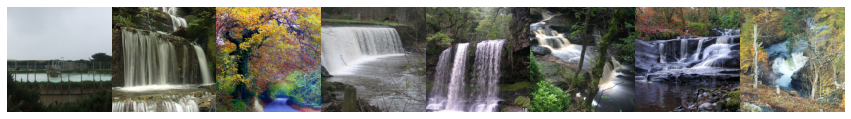

---------------------------------
waterfalls


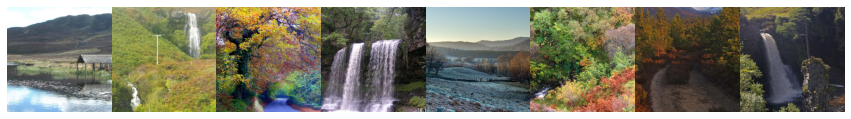

cascades


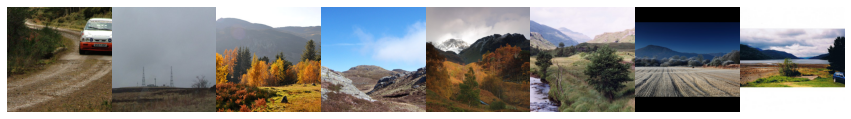

cascading


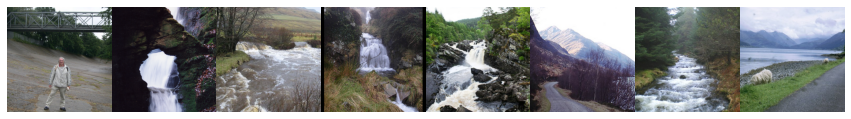

gorge


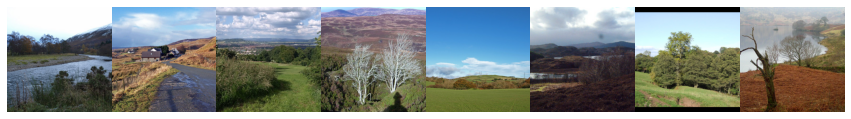

pond


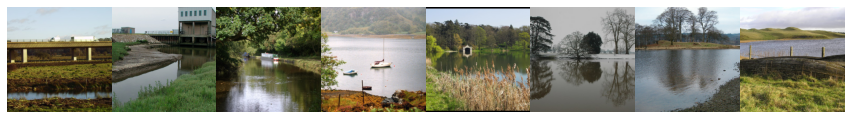

fountains


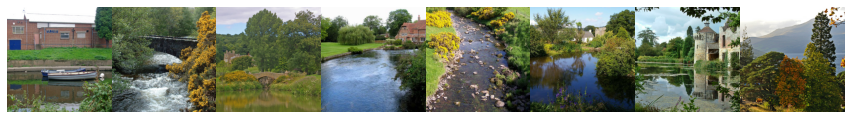

ledge


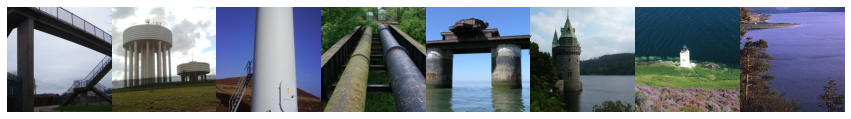

ravine


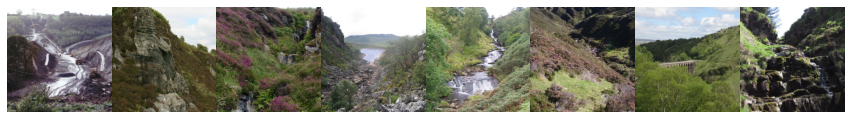

picturesque


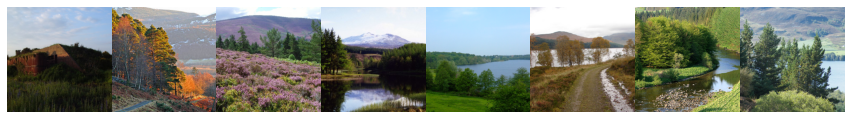

gully


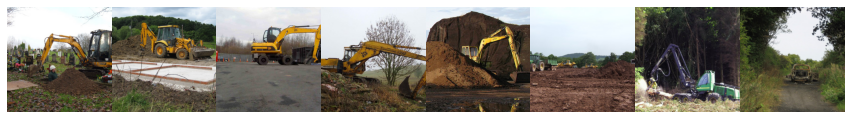

In [25]:
viewImages('waterfall', 8, LAPTOP_PIM)